# Reinforcment Learning Assignment
## Q-Learning with Frozen Lake
### Eoin Mc Allister - 20232319

Create FrozenLake and apply Q-Learning to an agent that exists within the enviroemnt


In [67]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt


### Game Parameters
Epsilon = 0.1 was not used here as an epsilon decay strategy was used which gave nicer results. rand num <= E gave a graph that didnt show much. Hard to measure performance as theres a 10% the agent does something random

In [68]:
BoardSize = (5, 5)                  # Size of the Frozen Lake environment
WinPos = (4, 4)                     # The Position the Agent much try and reach
StartPos = (0, 0)                   # Where the agent starts

TerminalReward = 10                 # The reward for reaching the WinPos
HoleReward = -5                     # The reward for falling into a hole in the lake
TransitionReward = -1               # The reward for moving through the environment

HolePos = (1, 0), \
          (1, 3), \
          (3, 1), \
          (4, 2)                    # Positions of all the holes in the Lake

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
NumActions = 4                      # Possible Actions

num_episodes = 10000                # Number of times the agent will play the game
max_steps_per_episode = 1000        # Max Number of steps before game ends

alpha = 0.5                         # Learning Rate for Q-Table Updates
gamma = 0.9                         # Discount Rate for Q-Table Updates
epsilon = 1.0                       # Epsilon Value for E-Greedy Strategy
min_epsilon = 0.1                   # Minimum Value for Epsilon
epsilon_decay = 0.9996              # Decay rate of Epsilon

q_table = np.zeros((                # Creates the Q-Table in the Shape of Number of Positions * Number of Actions
    BoardSize[0] * BoardSize[1],
    NumActions))

rewards_all_episodes = []           # Array to hold Rewards from each Episode

## Frozen Lake Environment
Creates the frozen lake environment with capabilities of moving around and processing rewards

In [69]:
class Lake:
    def __init__(self,
                 state=StartPos,
                 end_pos=WinPos,
                 map_size=BoardSize,
                 holes=HolePos,
                 actions=(UP, DOWN, LEFT, RIGHT),
                 rewards=(TerminalReward, HoleReward, TransitionReward)):

        self.state = state
        self.done = False
        self.end_pos = end_pos

        self.nrow, self.ncol = map_size
        self.holes = holes
        self.actions = actions

        self.r_terminal, self.r_hole, self.r_transition = rewards

        self.ending_array = []

        self.map = self._gen_map()
        print('\n')
        print('Map')
        print(self.map)

    def _gen_map(self):
        """
        Generates the Frozen Lake
        :return: the map
        """
        mp = [['F' for _ in range(self.ncol)] for _ in range(self.nrow)]
        mp[self.state[0]][self.state[1]] = 'S'
        mp[self.end_pos[0]][self.end_pos[1]] = 'G'
        for h in self.holes:
            mp[h[0]][h[1]] = 'H'
        mp = ["".join(x) for x in mp]
        return np.asarray(mp, dtype='c')

    def get_reward(self):
        """
        Gets the reward returned for landing on the current state
        :return:
        """
        letter = self.map[self.state[0]][self.state[1]]
        reward = 0
        if letter in b'G':
            reward = self.r_terminal
        elif letter in b'H':
            reward = self.r_hole
        # Start is included as if start pos is by an edge, moving towards said edge
        # will result in landing in the same spot and this counts as a transition
        elif letter in b'FS':
            reward = self.r_transition
        return reward

    def move(self, act):
        """
        Moves the agent from the current position to a new position based on the action passed
        :param act: Which Action is being taken
        """
        row, col = self.state[0], self.state[1]

        if act == UP:
            row = max(row - 1, 0)
        elif act == DOWN:
            row = min(row + 1, self.nrow - 1)
        elif act == LEFT:
            col = max(col - 1, 0)
        elif act == RIGHT:
            col = min(col + 1, self.ncol - 1)
        self.state = (row, col)

    def is_done(self):
        """
        Determines if the agent is done - Has reached a hole or a goal
        """
        self.done = bytes(self.map[self.state[0]][self.state[1]]) in b'GH'
        let = self.map[self.state[0]][self.state[1]]
        if self.done:
            self.ending_array.append([1 if let in b'G' else 0])
        if self.done:
            self.state = StartPos
        return self.done

    def step(self, action):
        self.move(action)  # Make agent take action and move to new state
        reward = self.get_reward()  # Get reward for taking that action
        done = self.is_done()  # Is game done
        new_state = self.state[0] * 5 + self.state[1]  # Get the new position of the agent and convert to Q Table lookup

        return reward, new_state, done

## Playing The Game
Creates the environment and allows for movement around the environment. Returns the reward from each position and ends the game if the agent falls in a hole, reaches the end or maxes out steps
Returns the updated Q-Table, and the rewards

In [70]:
def game(q_tab, initial_eps):
    env = Lake()
    epsilon = initial_eps
    for episode in range(num_episodes):
        if episode % 500 == 0:
            print('\n')
            print('Episode:', episode + 1, "/", num_episodes)
        episode_reward = 0
        state = env.state[0] * 5 + env.state[1]

        epsilon = epsilon * epsilon_decay

        for step in range(max_steps_per_episode):

            # Get Action based on Greedy Strategy
            eps = max(min_epsilon, epsilon)
            if np.random.random() <= eps:
                action = np.random.randint(0, 4)
            else:
                action = np.argmax(q_table[state, :])

            # Take Action to move to new state and get reward
            reward, new_state, done = env.step(action)
            episode_reward += reward

            # print(reward, new_state, done, action)

            # Update Q-Table
            q_tab[state, action] = q_tab[state, action] * (1 - alpha) + alpha * (
                    reward + gamma * np.max(q_tab[new_state, :]))

            state = new_state

            # If done go to next episode
            if done:
                if episode % 500 == 0:
                    print('Episode Reward:', episode_reward)
                    print('Steps:', step + 1)
                rewards_all_episodes.append(episode_reward)
                break

    return q_tab, rewards_all_episodes, env.ending_array

## Plotting Results
Plots the results from all episodes

In [71]:
def plot_result(rews, end):
    y = np.asarray(rews)

    x_wins = np.where(np.asarray(end) == 1)[0]
    x_fails = np.where(np.asarray(end) == 0)[0]

    y_wins = np.take(y, x_wins)
    y_fails = np.take(y, x_fails)

    plt.scatter(x=x_wins, y=y_wins, c='g', s=0.8, label='Win')
    plt.scatter(x=x_fails, y=y_fails, c='r', s=0.8, label='Fail')

    plt.title('Agent Reward Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

## Getting Results



Map
[[b'S' b'F' b'F' b'F' b'F']
 [b'H' b'F' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'G']]


Episode: 1 / 10000
Episode Reward: -7
Steps: 3


Episode: 501 / 10000
Episode Reward: -6
Steps: 2


Episode: 1001 / 10000
Episode Reward: -5
Steps: 1


Episode: 1501 / 10000
Episode Reward: 2
Steps: 9


Episode: 2001 / 10000
Episode Reward: -3
Steps: 14


Episode: 2501 / 10000
Episode Reward: 1
Steps: 10


Episode: 3001 / 10000
Episode Reward: 2
Steps: 9


Episode: 3501 / 10000
Episode Reward: -1
Steps: 12


Episode: 4001 / 10000
Episode Reward: -10
Steps: 6


Episode: 4501 / 10000
Episode Reward: 3
Steps: 8


Episode: 5001 / 10000
Episode Reward: 3
Steps: 8


Episode: 5501 / 10000
Episode Reward: 2
Steps: 9


Episode: 6001 / 10000
Episode Reward: 3
Steps: 8


Episode: 6501 / 10000
Episode Reward: 3
Steps: 8


Episode: 7001 / 10000
Episode Reward: 3
Steps: 8


Episode: 7501 / 10000
Episode Reward: 3
Steps: 8


Episode: 8001 / 10000
Episode

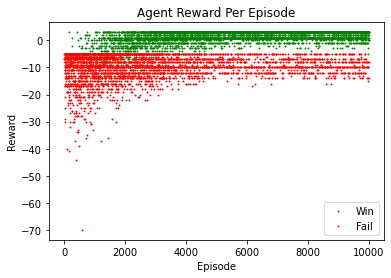

In [72]:
if __name__ == '__main__':
    q_table, rewards, end = game(q_table, epsilon)
    print(len(end))

    df_q = pd.DataFrame(q_table)

    print('\n')
    print(df_q)

    print('\n')
    print('Wins:', end.count([1]))
    print('Fails:', end.count([0]))

    plot_result(rewards, end)

## Discussion
N.B. A scatter plot was used instead of a line graph as the line graph was extremely unreadable. I feel the scatter plot displayed above gives a much deeper insight to the results. The enviroment is not complex enough to have a line plot which is readable. 
The agent gas successfully learned how to navigate through the lake. This is shown by the plot which displays the scores of the agent over every episode and whether or not it reached the Goal or not. As the episodes increase we can see less red dots appear and the scores are more consistently higher. It does appear that there are more Fails than Wins however, this is due to extreme over lapping of all the Winning scores. This is proven when the number of Wins and Fails are displayed. The model tends to achieve 6500-7500 wins each run.